# Telco Customer Churn Prediction, Based on  XGboost

Churn is one of the biggest challenges in the telecom industry. How can we predict potential churn to retain customers is vital for every telecom and service-oriented company. Based on machine learning models, we can analyze all relevant customer data and develop focused customer retention programs to reduce the financial loss of customer churn.

## 1. Dataset Description

**The dataset includes information about:**

**Customers who left within the last month** – the column is called Churn

**Services that each customer has signed up for** – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

**Customer account information** – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

**Demographic info about customers** – gender, age range, and if they have partners and dependents

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb #xgboost api
from sklearn.model_selection import train_test_split #dataset split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # data evaluation
from sklearn.model_selection import GridSearchCV # cross validation for tuning parameters
from sklearn.metrics import confusion_matrix # data evaluation
from sklearn.metrics import ConfusionMatrixDisplay # visualization of data evaluation

## **2. Data exploration**
Firstly, lets read dataset from csv file and show the first 5 rows of this dataset

In [2]:
#read data from csv file:
total_data = pd.read_csv('Customer_Churn.csv')
#show the first 5 rows of data:
total_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 1.1 Data clean:
 Note that total_data contains lots of columns that have an object data type, but **XGboost**, the model we are planning to use only allows **Boolean**, **Int**, and **Float** data types. In this case, We are supposed to convert dtype of these columns from object to boolean later in the process of formatting data.

In [4]:
#drop customer id column:
total_data.drop(['customerID'], axis = 1, inplace = True)

# convert data type of column 'TotalCharges' to float:
total_data['TotalCharges'].replace(' ', 0, regex = True, inplace = True)
total_data['TotalCharges'] = pd.to_numeric(total_data['TotalCharges'])

#replace all the space ' ' to '_'.
total_data.replace(' ', '_', regex = True, inplace = True)

#check the data types after converting:
total_data.info()
#get the number of null fo each column:
total_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 1.2 Numerical variable visualization:

At first glance, **TotalCharges** might be one of the most important features as a general rule.
In this case, I plotted the KDE( kernel density estimate ) of **TotalCharges** for different groups of customers.

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

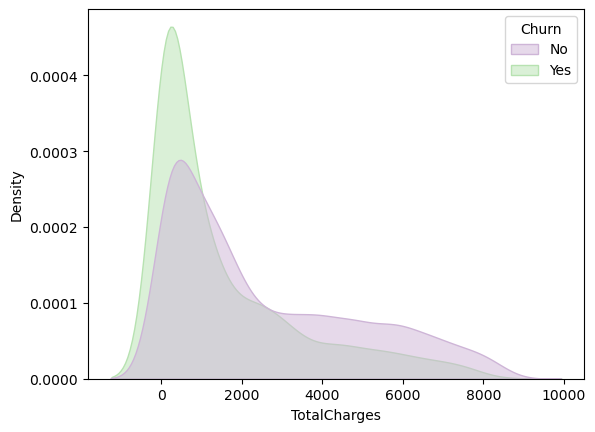

In [5]:
#Get the KDE of TotalCharges separated by the customers churn or not.
sns.set_palette('PRGn', n_colors = 2)
sns.kdeplot(x = 'TotalCharges',
             data = total_data,
             hue = 'Churn',
             alpha = .5,
             fill = True,
             common_norm = False)

##### It shows that customers who churned tend to have lower total charges than  customers who didn't churn.
<bar>
    
One of the reasons is that most of them had shorter tenure than other customers.
In this case, we use the joint plot to illustrate the effect of 'total charges' and 'tenure' on churn.

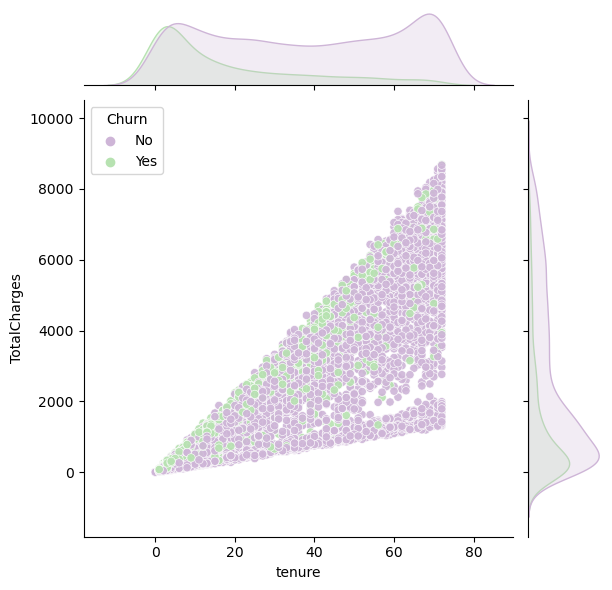

In [6]:
sns.jointplot(x = 'tenure',
             y = 'TotalCharges',
             data = total_data,
             kind = 'scatter',
             hue = 'Churn',
             alpha = .9)

#### An interesting thing is when tenures are the same, the customers who have higher total charges would be more likely to churn. In other words, the monthly charges may be another important factor that influences whether a customer churn or not.

So I get the jointplot to illustrate the effect of **Monthly Charges** and **tenure** on Churn. The graph below shows that cumstomers who have larger monthly charges and lower tenure are more likely to churn.

<bar> 
Besides, the KDE graph on the right shows higher mothly charges are more like to make customers churn, which is in line with the reality.

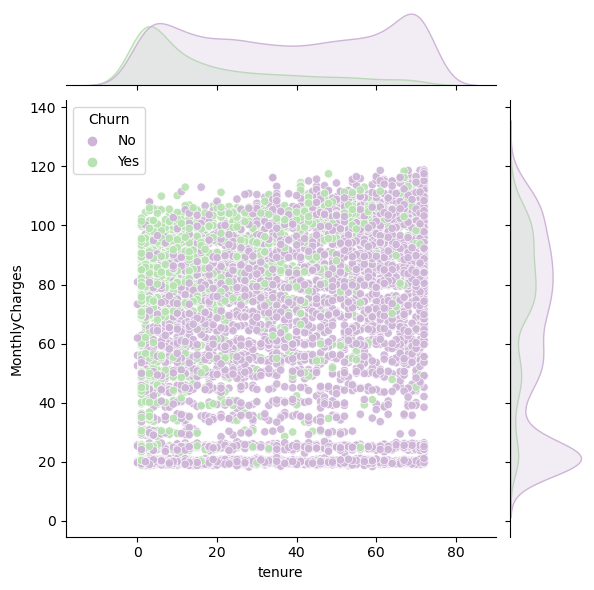

In [7]:
sns.jointplot(x = 'tenure',
             y = 'MonthlyCharges',
             data = total_data,
             kind = 'scatter',
             hue = 'Churn',
             alpha = .9)

### 1.3 Categorical variable visualization:

Firstly, we visualize the relationship between churn and demographic information. It shows that **gender** is not a significant feature. In the contrast, customers who don't have **partners** or **dependents** or who are not **senior citizens**, they are more like to churn.

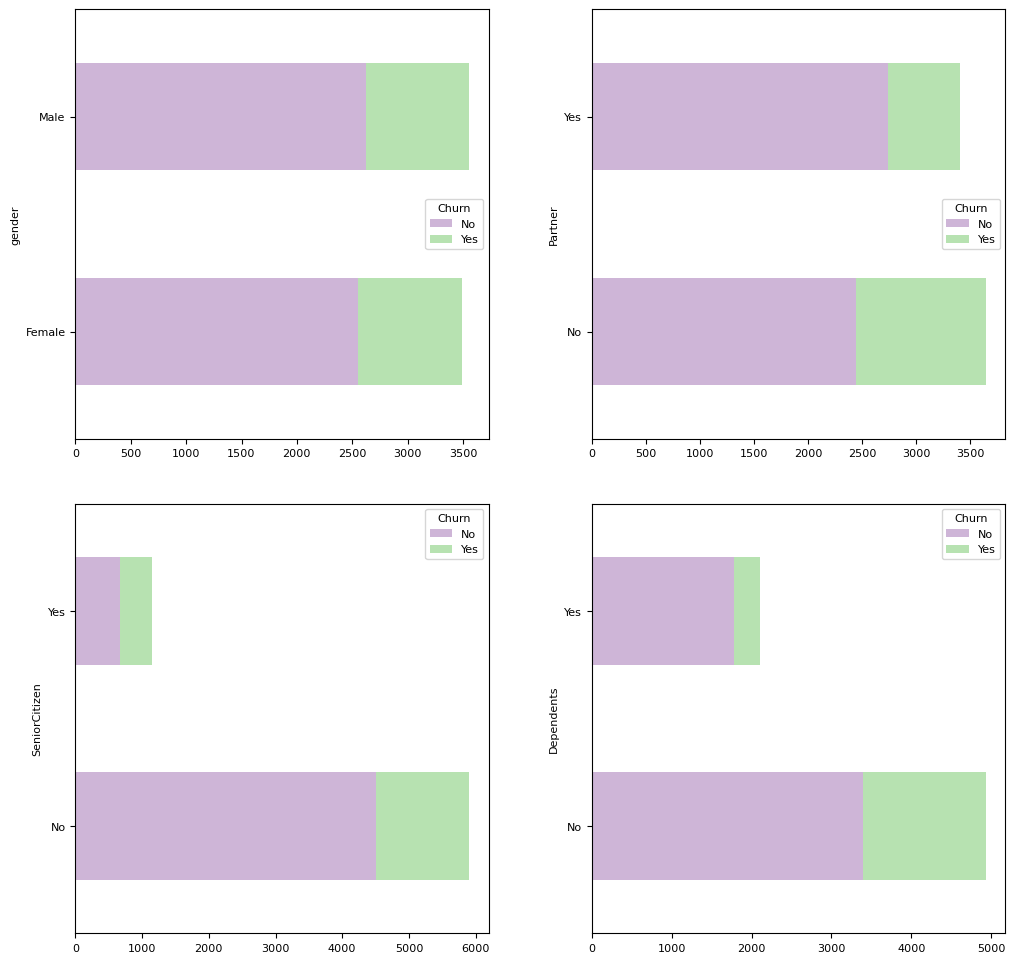

In [50]:
fig = plt.figure(figsize = [12,12])
gs = fig.add_gridspec(2,2, hspace = .15, wspace = .25)
axes = gs.subplots()

total_data.groupby('gender')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes[0,0])
total_data.groupby('Partner')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes[0,1])
total_data.groupby('SeniorCitizen')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes[1,0])
axes[1,0].yaxis.set_ticks([1,0])
axes[1,0].yaxis.set_ticklabels(['Yes','No'])


total_data.groupby('Dependents')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes[1,1])
plt.rcParams['font.size'] = 8

As for the service-related factors, customers who don't have **phone service** or **internet service** are less likely to churn. Besides, customers who don't have **online security** are more likely to churn.

<AxesSubplot:ylabel='OnlineSecurity'>

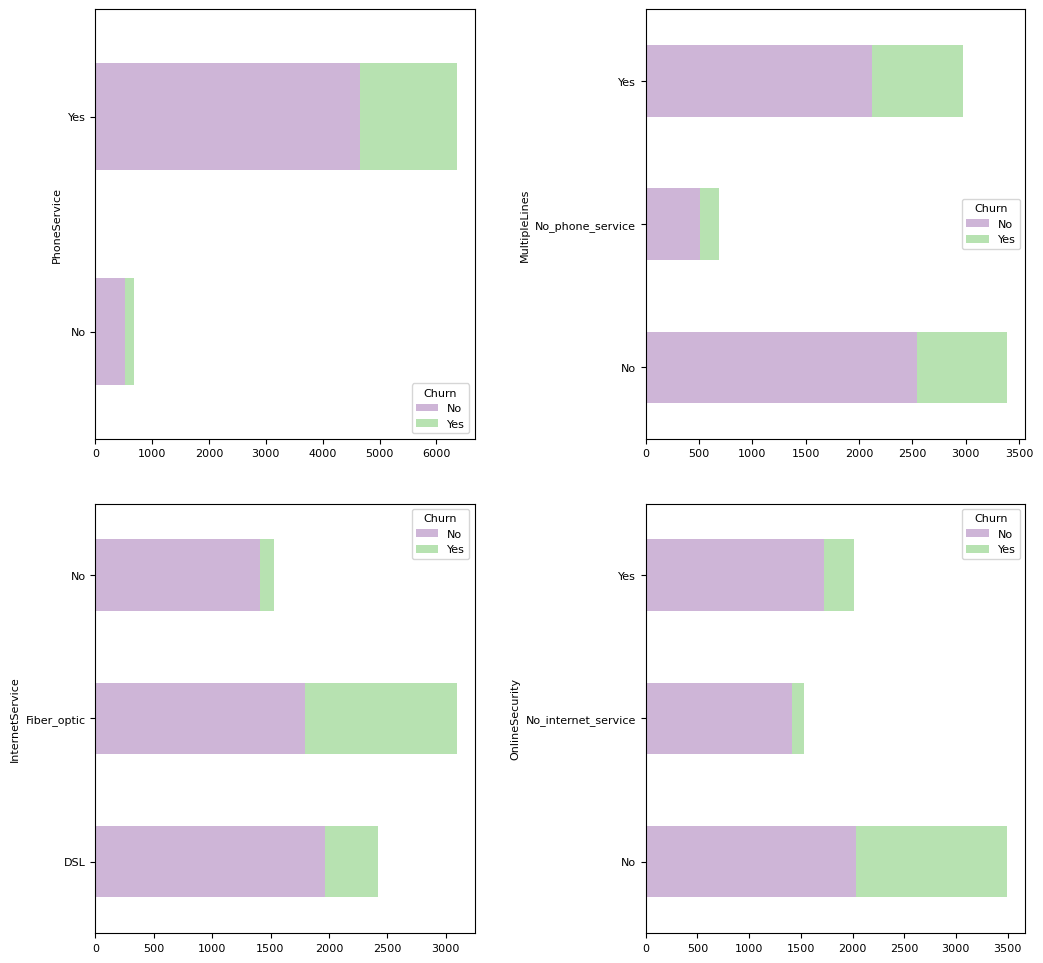

In [51]:
fig1 = plt.figure(figsize = [12,12])
gs1 = fig1.add_gridspec(2,2, hspace = .15, wspace = .45)
axes1 = gs1.subplots()


total_data.groupby('PhoneService')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes1[0,0])
total_data.groupby('MultipleLines')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes1[0,1])
total_data.groupby('InternetService')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes1[1,0])
total_data.groupby('OnlineSecurity')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes1[1,1])

Diving into the internet service features, we can find that customers who do not have **online backup**, **device protection**, or **tech support** are more likely to churn than those who have these services.

<AxesSubplot:ylabel='TechSupport'>

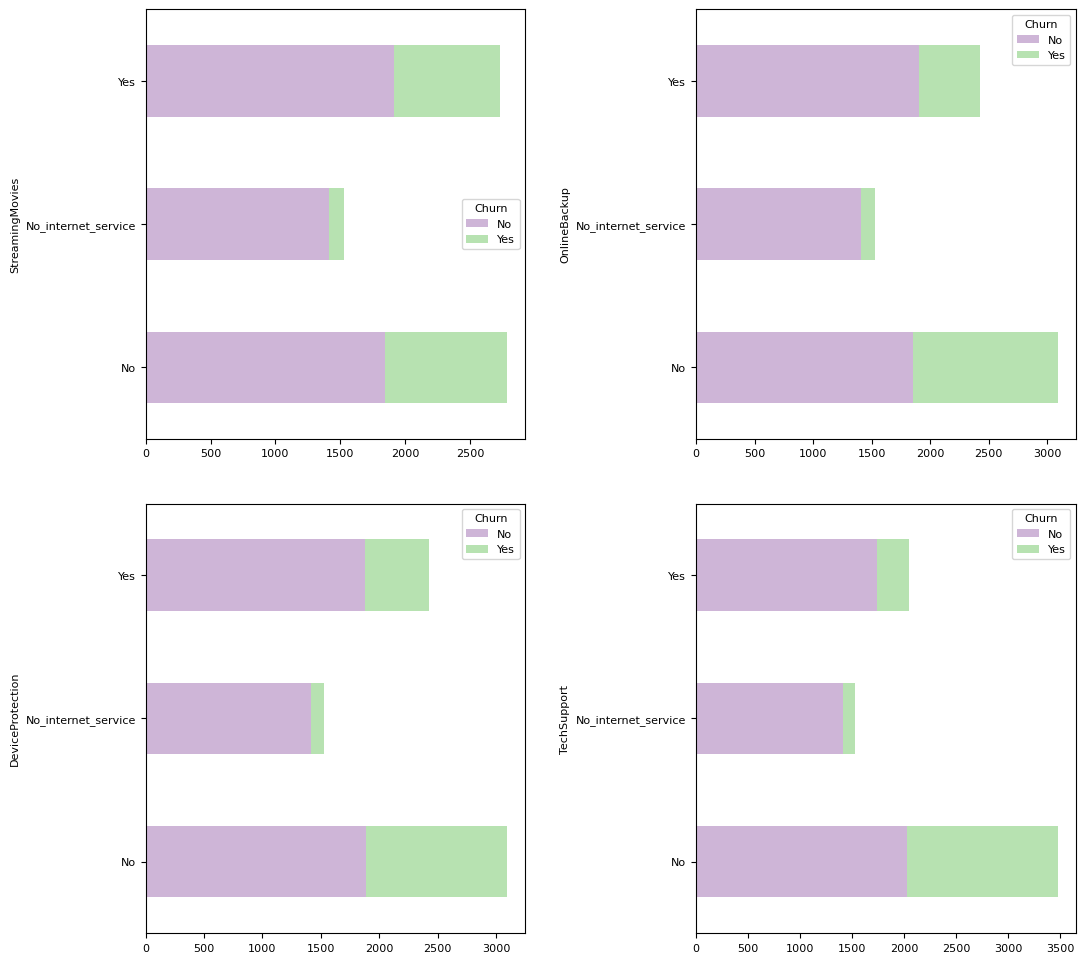

In [52]:
fig2 = plt.figure(figsize = [12,12])
gs2 = fig2.add_gridspec(2,2, hspace = .15, wspace = .45)
axes2 = gs2.subplots()


total_data.groupby('StreamingMovies')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes2[0,0])
total_data.groupby('OnlineBackup')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes2[0,1])
total_data.groupby('DeviceProtection')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes2[1,0])
total_data.groupby('TechSupport')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes2[1,1])

As for the customer account information, it shows that customers with **month-to-month contract**, **papperless bill**, or **eletronic check payment** have larger pobibility to churn from service.

<AxesSubplot:ylabel='PaymentMethod'>

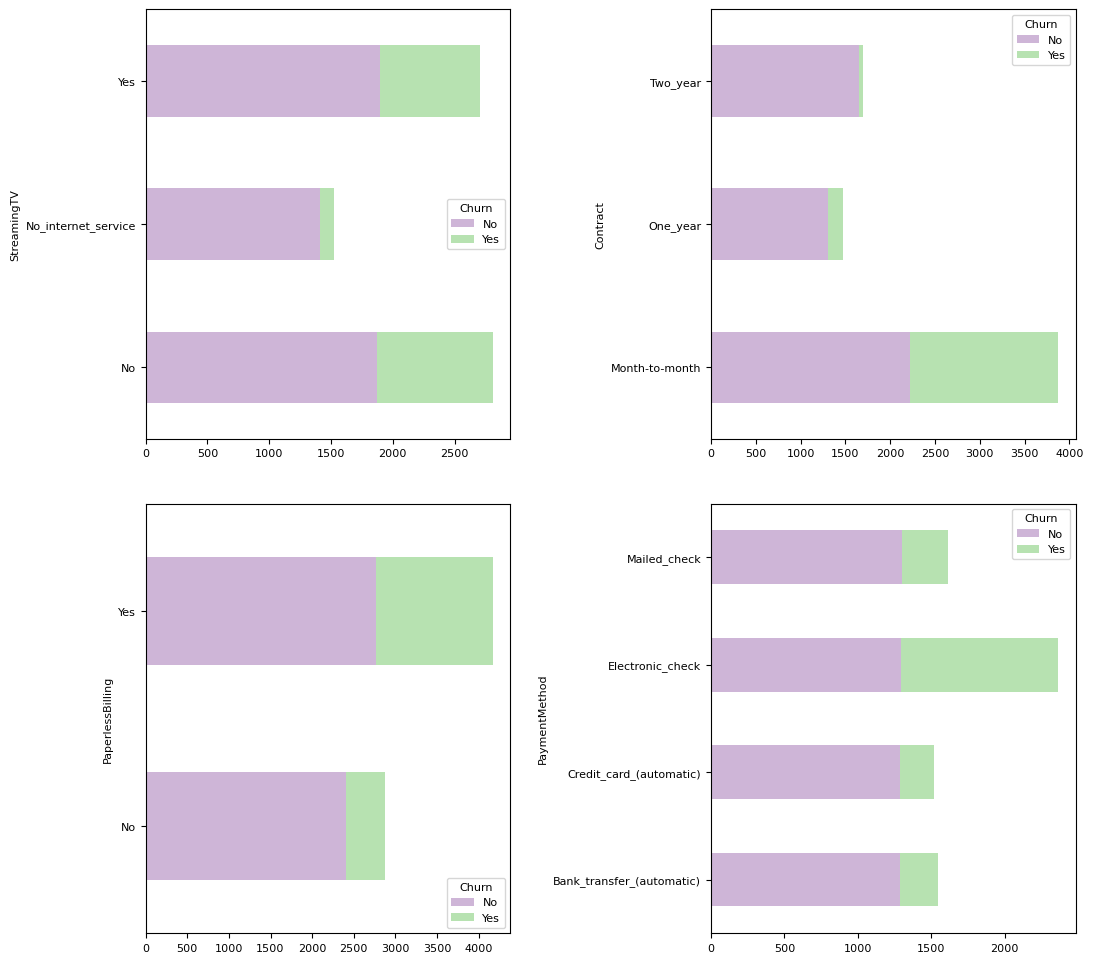

In [53]:
fig3 = plt.figure(figsize = [12,12])
gs3 = fig3.add_gridspec(2,2, hspace = .15, wspace = .55)
axes3 = gs3.subplots()


total_data.groupby('StreamingTV')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes3[0,0])

total_data.groupby('Contract')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes3[0,1])
total_data.groupby('PaperlessBilling')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes3[1,0])
total_data.groupby('PaymentMethod')['Churn'].value_counts().unstack().plot(kind = 'barh',
                                                                     stacked = True,
                                                                     ax = axes3[1,1])

## **3. Format Data**

Before building the models, formatting data is important to make data adapt to the **XGBoost** model.

### 3.1 Split dataest

The first step is to split the data into two pars:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict

In [12]:
churn = total_data['Churn'].copy()
churn.unique()

array(['No', 'Yes'], dtype=object)

In [13]:
#change the data type of churn
churn.replace({'No':0 , 'Yes':1}, inplace = True)

In [14]:
# get the predictors dataset
variables = total_data.drop('Churn', axis = 1)
variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


### 3.1 One-Hot encoding:
While **XGBoost** natively supports numeric data, it doesn't support categorical data, like **gender**, which contains 2 different categories. In this case, to involve categorical data in **XGBoost**, we are supposed to convert a column of categorical data into multiple columns of binary values, which we called **One-Hot Encoding**.

In [15]:
vdt = variables.dtypes.to_frame(name = 'dtype')
obj_var = list(vdt[vdt['dtype'] == 'object'].index)

In [16]:
x_encoded = pd.get_dummies(variables, columns = obj_var)
x_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


## **4. Model Building**

Since we already got the **churn** dataset which contains the dependent variable, and the **variables** dataset which contains explanatory variables.
Splitting thess datasets into train data and test data is the last left before we begin to build the model.
Because of the **imbalance** of dependent variables, **stratified sampling** is a good way to split the datasets with the same stratify.

In [17]:
# get proportion of churned customers in original dataset.
sum(churn)/len(churn)

0.2653698707936959

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_encoded,
                                                    churn,
                                                    test_size = .2,
                                                    random_state = 777,
                                                    stratify = churn)

In [19]:
#get proportion of churned customers in train data.
sum(y_train)/len(y_train)

0.2653532126375577

In [20]:
#get proportion of churned customers in test data.
sum(y_test)/len(y_test)

0.2654364797728886

### 4.1 Build a simple **XGBoost** model

In [21]:
xgb_simple = xgb.XGBClassifier(objective = 'binary:logistic',  
                               seed = 777) 

In [22]:
xgb_simple.set_params(early_stopping_rounds = 10, #set early stopping rounds to increase the effiency of modeling
                      eval_metric = 'aucpr') # set evaluation metric which is the method checking the performance of learning

xgb_simple.fit(X_train,
               y_train,
               verbose = 10,
               eval_set = [(X_train, y_train)])

[0]	validation_0-aucpr:0.68552
[10]	validation_0-aucpr:0.77293
[20]	validation_0-aucpr:0.80285
[30]	validation_0-aucpr:0.83688
[40]	validation_0-aucpr:0.85948
[50]	validation_0-aucpr:0.88371
[60]	validation_0-aucpr:0.90185
[70]	validation_0-aucpr:0.92046
[80]	validation_0-aucpr:0.93325
[90]	validation_0-aucpr:0.94738
[99]	validation_0-aucpr:0.95879


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Then we get confusion metrics to evaluate the performance of the simple XGBoost model in the test data.
It shows that the **specificity**(True Negative Rate) is **88%**, which is a good performance in predicting the customers who don't churn. However, the **Sensitivity**(True Postiive Rate) is only **51%**, which is not satisfying. Especially when our primary goal is to predict the potential churn of customers, we are supposed to improve the performance in the sensitivity of our model.

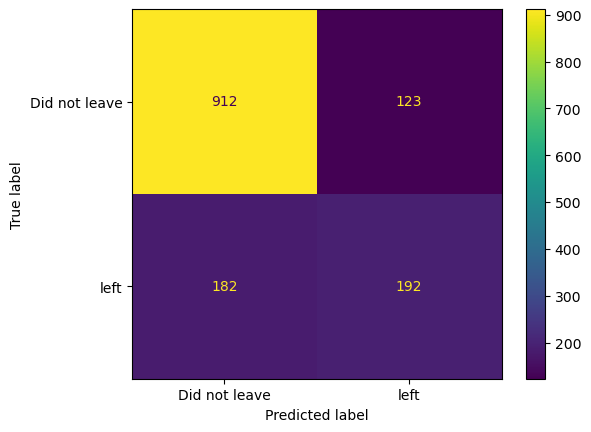

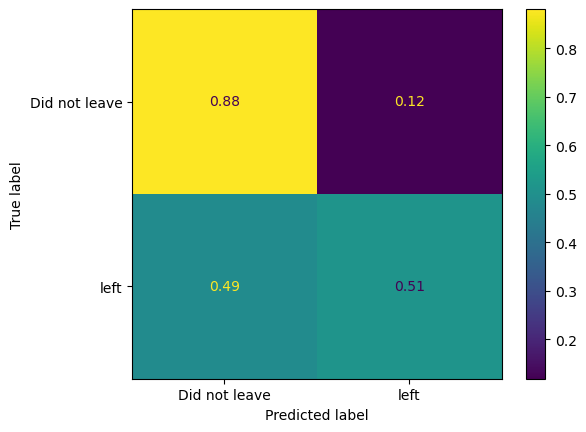

In [23]:
ConfusionMatrixDisplay.from_estimator(xgb_simple, 
                                      X_test, 
                                      y_test, 
                                      display_labels = ['Did not leave', 'left'])

ConfusionMatrixDisplay.from_estimator(xgb_simple, 
                                      X_test, 
                                      y_test, 
                                      display_labels = ['Did not leave', 'left'],
                                      normalize = 'true')

One of the most common ways to improve the accuracy of models is tuning the parameters of XGBoost. We are going to tune **max depth**, **learning rate**, **gamma**, and **reg_lambda** parameters by cross-validation. Besides, we decrease the values of **subsample** and **colsample by tree** parameters when conducting each tree to reduce the time of modeling and avoid overfitting.

In [25]:
param_grid = {'max_depth': [3, 4, 5],
              'learning_rate':[.01, .05, .1 , .15],
              'gamma': [0, .25, .5, 1],
              'reg_lambda': [1, 5, 10]}
optimal_params1 = GridSearchCV(
                estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                              seed = 777,
                                              subsample = .9,
                                              colsample_bytree = .5,
                                              n_estimators = 200,                   
                                              early_stopping_rounds = 10,
                                              eval_metric = 'aucpr',),
                param_grid = param_grid,
                scoring = 'roc_auc',
                verbose = 0,
                n_jobs = 10,
                cv = 4)

In [26]:
optimal_params1.fit(X_train,
                   y_train,
                   eval_set = [(X_train, y_train)],
                   verbose = False)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

#### Then we get the best parameters below after tuning:

In [27]:
optimal_params1.best_params_

{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10}

In [39]:
# build a new XGBoost model with the best parameters we tuned before:
xgb_1 = xgb.XGBClassifier(objective = 'binary:logistic',
                          seed = 777,
                          subsample = .9,
                          colsample_bytree = .5,
                          gamma = 0.5,
                          learning_rate = .05,
                          max_depth = 3,
                          reg_lambda = 10,
                          n_estimators = 200)

xgb_1.set_params(early_stopping_rounds = 10,
                 eval_metric = 'aucpr')

xgb_1.fit(X_train,
          y_train,
          verbose = 10,
          eval_set = [(X_train, y_train)])

[0]	validation_0-aucpr:0.58339
[10]	validation_0-aucpr:0.64537
[20]	validation_0-aucpr:0.66173
[30]	validation_0-aucpr:0.66639
[40]	validation_0-aucpr:0.67103
[50]	validation_0-aucpr:0.67691
[60]	validation_0-aucpr:0.68097
[70]	validation_0-aucpr:0.68527
[80]	validation_0-aucpr:0.68801
[90]	validation_0-aucpr:0.69115
[100]	validation_0-aucpr:0.69294
[110]	validation_0-aucpr:0.69504
[120]	validation_0-aucpr:0.69682
[130]	validation_0-aucpr:0.69848
[140]	validation_0-aucpr:0.69988
[150]	validation_0-aucpr:0.70131
[160]	validation_0-aucpr:0.70300
[170]	validation_0-aucpr:0.70469
[180]	validation_0-aucpr:0.70636
[190]	validation_0-aucpr:0.70791
[199]	validation_0-aucpr:0.70909


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### We get the confusion metrics to evaluate the performance of the tuned XGBoost model in test data.
It shows that the **specificity**(True Negative Rate) is **90%**, which is slightly improved in terms of the performance in predicting the customers who don't churn. However, the **Sensitivity**(True Postiive Rate) is still **51%**. Obviouly, this is not the result we would expect to see.

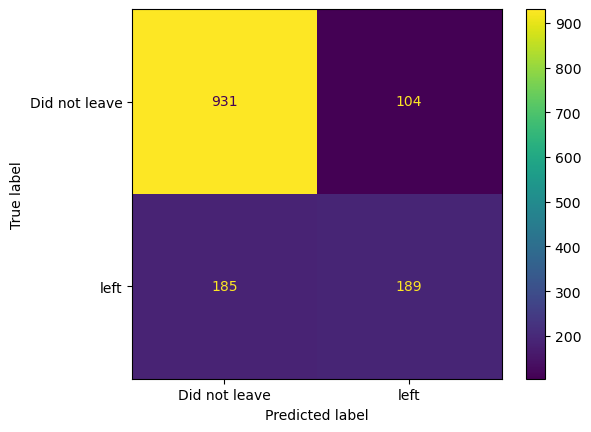

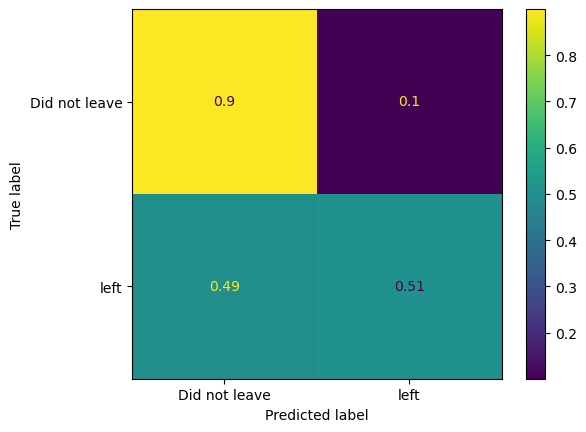

In [40]:
ConfusionMatrixDisplay.from_estimator(xgb_1,
                                      X_test,
                                      y_test,
                                      display_labels = ['Did not leave','left'])

ConfusionMatrixDisplay.from_estimator(xgb_1,
                                      X_test,
                                      y_test,
                                      display_labels = ['Did not leave','left'],
                                      normalize = 'true')

One of the reasons is that our data are imbalanced which means the number of customers who don't leave is significantly larger than the number of customers who churn. To fix this issue, we are supposed to balance the positive and negative weight via **scale_pos_weight** parameter(which is recommended to be the **sum(negative instances)/sum(positive instances))**.

More than this, we increase the number of potential values for each parameter and add two more parameters, **colsample_bytree** and **subsample** to be tuned.

In [30]:
param_grid = {'max_depth': [3, 4, 5, 7],
              'learning_rate':[.01, .05, .1 , .15],
              'gamma': [0, .25, .5, .75],
              'reg_lambda': [10, 15, 20],
              'colsample_bytree': [.3, .5, .7,],
              'subsample': [.5, .7, .9]}

spw = len(y_train[y_train == 0])/len(y_train[y_train == 1])

optimal_params1 = GridSearchCV(
                estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                              seed = 777,
                                              #set scale_pos_weight as len(negative)/len(positive)
                                              scale_pos_weight = spw,
                                              n_estimators = 300,
                                              early_stopping_rounds = 10,
                                              eval_metric = 'aucpr'),
                param_grid = param_grid,
                scoring = 'roc_auc',
                verbose = 0,
                n_jobs = 20,
                cv = 4)

In [31]:
optimal_params1.fit(X_train,
                    y_train,
                    eval_set = [(X_train, y_train)],
                    verbose = False)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=300, n_jobs=None,
                         

#### Then we get the best parameters below after the second tuning:

In [32]:
optimal_params1.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 3,
 'reg_lambda': 20,
 'subsample': 0.5}

In [36]:
## build a new XGBoost model with the best parameters we tuned before and the scale_pos_weight parameter:
xgb_2 = xgb.XGBClassifier(objective = 'binary:logistic',
                          seed = 777,
                          gamma = .25,
                          learning_rate = .05,
                          reg_lambda = 20,
                          max_depth = 3,
                          scale_pos_weight = spw,
                          subsample = .5,
                          colsample_bytree = 0.5,
                          n_estimators = 300)

xgb_2.set_params(early_stopping_rounds = 10,
                 eval_metric = 'aucpr')

xgb_2.fit(X_train,
          y_train,
          verbose = 10,
          eval_set =[(X_train, y_train)])

[0]	validation_0-aucpr:0.53844
[10]	validation_0-aucpr:0.63403
[20]	validation_0-aucpr:0.64865
[30]	validation_0-aucpr:0.65287
[40]	validation_0-aucpr:0.66550
[50]	validation_0-aucpr:0.67388
[60]	validation_0-aucpr:0.67829
[70]	validation_0-aucpr:0.68171
[80]	validation_0-aucpr:0.68396
[90]	validation_0-aucpr:0.68533
[100]	validation_0-aucpr:0.68930
[110]	validation_0-aucpr:0.69028
[120]	validation_0-aucpr:0.69163
[130]	validation_0-aucpr:0.69279
[140]	validation_0-aucpr:0.69424
[150]	validation_0-aucpr:0.69544
[160]	validation_0-aucpr:0.69649
[170]	validation_0-aucpr:0.69781
[180]	validation_0-aucpr:0.69856
[190]	validation_0-aucpr:0.69940
[200]	validation_0-aucpr:0.70029
[210]	validation_0-aucpr:0.70178
[220]	validation_0-aucpr:0.70269
[230]	validation_0-aucpr:0.70288
[240]	validation_0-aucpr:0.70376
[250]	validation_0-aucpr:0.70510
[260]	validation_0-aucpr:0.70613
[270]	validation_0-aucpr:0.70700
[280]	validation_0-aucpr:0.70809
[290]	validation_0-aucpr:0.70899
[299]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Then we get the confusion metrix to evaluate the performance of the final XGBoost model in test data.
there is a exciting result shows the **Sensitivity**(True Postitive Rate) is **82%** now, which increases from **51%**.It is a surprising improvement in predicting the customers who actually churn. There are trade-off for this improvement which is the decrease of **specificity**(True Negative Rate) which decrease from **90%** to **74%**. However, since the primary goal of our model is to predict the potential churn of customers , and financially speaking, the financial loss of customer churn is more awful than the extra cost of mispredicting customers who would not churn. **In this case, the trade-off in specificity of our model is acceptable.**

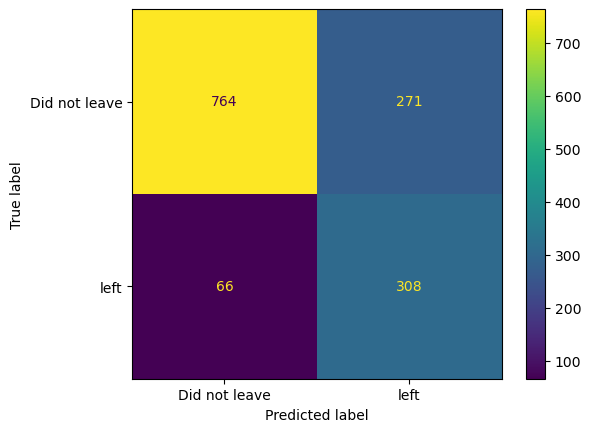

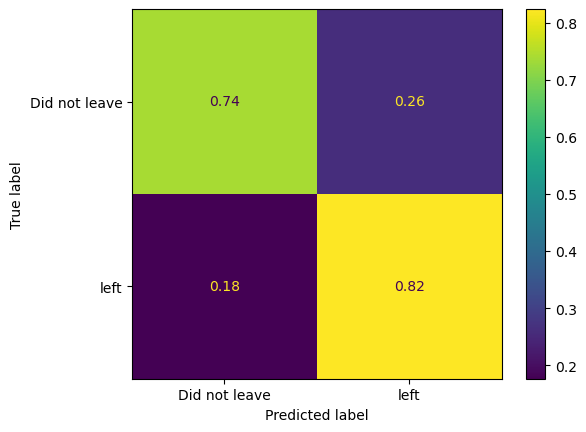

In [37]:
ConfusionMatrixDisplay.from_estimator(xgb_2,
                                      X_test,
                                      y_test,
                                      display_labels = ['Did not leave','left'])

ConfusionMatrixDisplay.from_estimator(xgb_2,
                                      X_test,
                                      y_test,
                                      display_labels = ['Did not leave','left'],
                                      normalize = 'true')

In the end, we get the bar graph of feature importance. It shows that **MonthlyCharge**, **TotalCharges**, and **tenure** are the top three important features when we predict customer churn.

In [58]:
roc_auc_score(y_test,xgb_2.predict(X_test))

0.7808468314862178

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

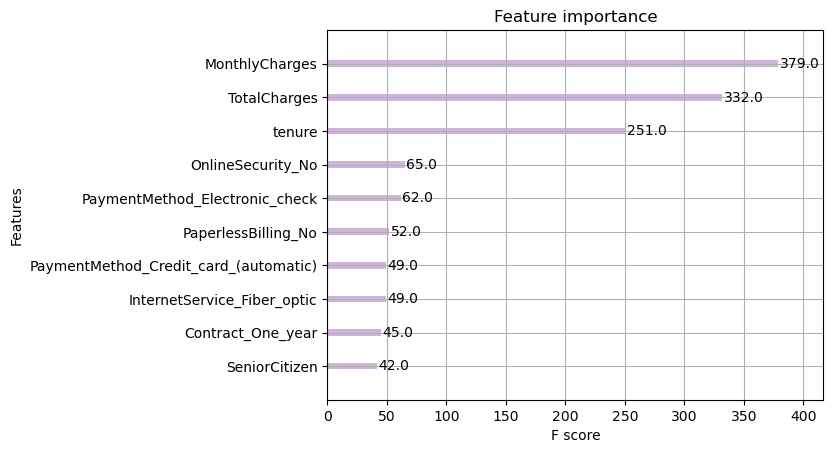

In [38]:
xgb.plot_importance(xgb_2, max_num_features = 10)